In [11]:
'''

The purpose/objective of this notebook is :


The following notebooks should be run before this notebook or are used to generate input files for the notebook:




# save all the global variable in a dataclass G
@dataclass
class G():
    Class to hold global variables
    write_dir='/home/ubuntu/write/'
    repo_parent_dir='../../'
    WRITE_CACHE=False
    #input files

    #output files

    #variables to change
    save_output=True
    save_output_figures=False


'''

"\n\nThe purpose/objective of this notebook is :\n\n\nThe following notebooks should be run before this notebook or are used to generate input files for the notebook:\n\n\n\n\n# save all the global variable in a dataclass G\n@dataclass\nclass G():\n    Class to hold global variables\n    write_dir='/home/ubuntu/write/'\n    repo_parent_dir='../../'\n    WRITE_CACHE=False\n    #input files\n\n    #output files\n\n    #variables to change\n    save_output=True\n    save_output_figures=False\n\n\n"

In [12]:
%%bash
cd
pwd
cd /home/ubuntu/data/ARCHS4/
ls

/home/ubuntu
archs4_gene_human_v2.1.2.h5
human_gene_v2.2.h5


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


## Global variables

In [13]:
# save all the global variable in a dataclass G
from dataclasses import dataclass
@dataclass
class G():
    '''Class to hold global variables'''
    write_dir='/home/ubuntu/write/'
    repo_parent_dir='../../'
    WRITE_CACHE=False
    #input files
    #ARCHS4_H5_file='/home/ubuntu/data/ARCHS4/archs4_gene_human_v2.1.2.h5'
    ARCHS4_H5_file='/home/ubuntu/data/ARCHS4/human_gene_v2.2.h5'

    #output files
    filtered_meta_data_csv_file='meta_samples_dermatitis.csv'

    #variables to change
    save_output=True
    save_output_figures=False

    

# libraries standard paths and settings

In [4]:
#write_dir='/home/ubuntu/write/'
#repo_parent_dir='../../'

import sys
if G.repo_parent_dir not in sys.path:
    sys.path.append(G.repo_parent_dir)

import adata_and_scanpy_tools as asctl

import pandas as pd
import scanpy as sc
import numpy as np
import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

#WRITE_CACHE=False # use false if  in github repo or cache files not in git ignore

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [6]:
### import extra packages
import h5py
import scipy as sp
import h5sparse

# Analysis starts here:

### filter  and other functions

In [7]:
def load_ARCHS4_H5_to_df( ARCHS4_H5_file):
    '''load a ARCHS4_H5 file to a pandas dataframe'''
    ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
    meta_samples = ARCHS4_H5['meta/samples']
    df = pd.DataFrame()
    for name, item in meta_samples.items():
        if isinstance(item, h5py.Dataset):
            values = item[:]
            values = [val.decode('utf-8') if isinstance(val, bytes) else val for val in values]
            df[name]= values
            df[name]= df[name].astype(item.dtype) 
    # now re order the columns
    new_column_order=['geo_accession', 'title', 'type','characteristics_ch1','source_name_ch1', 'sample','series_id','molecule_ch1', 'extract_protocol_ch1', 'readsaligned', #'readstotal',
                       'library_selection', 'library_source', 'library_strategy',  'singlecellprobability', 'submission_date', 'data_processing',
                      'status', 'last_update_date',  'channel_count',  'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 
                        'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute']

    df = df[new_column_order].copy()
    return df


def basic_filter_for_bulk_RNAseq(df, min_singlecellprobability=.5,min_readsaligned=1,max_readsaligned=1e15):
    '''filter the df to only include bulk RNAseq
    min_singlecellprobability: float, default .5
    min_readsaligned=1: int, default 1
    ,max_readsaligned=1e15: int, default  1e15
    '''
    df=df.loc[(df['library_selection'].isin(['cDNA']))
              &(df['molecule_ch1'].isin(['total RNA','polyA RNA']))
              &(df['singlecellprobability']<min_singlecellprobability)
              &(df['readsaligned']>=min_readsaligned)
              &(df['readsaligned']<=max_readsaligned)
              ,:].copy()
    print('filtering for library_selection = cDNA')
    print('filtering for molecule_ch1 =total RNA or polyA RNA')
    print(f'filtering for singlecellprobability <{min_singlecellprobability}')
    return df

def filter_df(df, search_strings, include=True,ignore_columns=None):
    # now filter rows of df to only include rows where an arbitrary list of string is present
    bolean_table= df.applymap(lambda x: x if pd.isnull(x) else any(search_string in x for search_string in search_strings) if isinstance(x, str) else False)
    # now remove the columns that are in ignore_columns from the bolean_table 'result' df
    if ignore_columns:
       bolean_table=bolean_table.drop(columns=ignore_columns)
    if include:
        df=df.loc[bolean_table.any(axis=1),:].copy()
        print(f'filtering to include {search_strings}')
    else:
        df=df.loc[~bolean_table.any(axis=1),:].copy()
        print(f'filtering to exclude {search_strings}')
    return df

def split_characteristics_ch1(df):
    ### this funciton split the characteristics_ch1 column into multiple columns
    return df

def return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=False):
    '''return adata from a h5 file and a filtered metadata df
    ARCHS4_H5: h5 file
    filtered_metadata_df: dataframe with the same index as the ARCHS4_H5
    return_df_only=False
    '''
    import anndata
    import pandas as pd
    #make var (gene) dataframe
    gene_symbols = ARCHS4_H5['meta/genes']['symbol'][:].astype('U')
    ensembl_gene_id  = ARCHS4_H5['meta/genes']['ensembl_gene_id'][:].astype('U')
    gene_biotype  = ARCHS4_H5['meta/genes']['biotype'][:].astype('U')
    var=pd.DataFrame(ensembl_gene_id,index=gene_symbols,columns=['ensembl_gene_id'])
    var['biotype']=gene_biotype
    # make obs (sample) dataframe
    samples_idx=filtered_metadata_df.index.tolist()
    obs=filtered_metadata_df.copy()
    obs['ARCHS4_idx']=samples_idx
    obs.index.name='geo_accession'
    # make data (expression) dataframe
    data_gex = ARCHS4_H5['data/expression'][:,samples_idx].T
    samples=filtered_metadata_df['geo_accession'].tolist()
    df_gex = pd.DataFrame(data_gex,columns=gene_symbols,index=samples)
    df_gex.index.name='geo_accession'
    # make adata
    adata = anndata.AnnData(X=data_gex,
                            obs=obs,
                            var=var,
                             dtype=np.float32)
    adata.var_names_make_unique()
    adata.obs_names=samples

    # return adata or df
    if return_df_only:
        return df_gex
    else:
        return adata

## all in one cell example for loading ARCHS4_H5_file and extracting subset of samples into an adata

In [8]:
ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
    
#df_meta_src=load_ARCHS4_H5_to_df( G.ARCHS4_H5_file )
#df_meta=df_meta_src.copy()
df_meta=load_ARCHS4_H5_to_df(G.ARCHS4_H5_file)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=.5)
min_singlecellprobability=.5
print(df_meta.shape)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=min_singlecellprobability)
print(df_meta.shape)
# list of Strings to check for to include
search_strings_include=['dermatitis', 'Dermatitis']
df_meta=filter_df(df_meta, search_strings_include, include=True,ignore_columns=['data_processing'] )
print(df_meta.shape)
# list of Strings to check for to exclude
#search_strings_exclude=['GABAergic', 'gabaergic', 'GABA', 'gaba', 'inhibitory', 'Inhibitory']
#df_meta_src=filter_df(df_meta_src, search_strings_exclude, include=False,ignore_columns=None)
print(df_meta.shape)
df_meta.to_csv(G.filtered_meta_data_csv_file, index=False)
#filtered_metadata_df=df_meta.copy()
#df_gex=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=True)
adata=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, df_meta,return_df_only=False)
print(adata)
adata.obs.head()

filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.5
(463217, 30)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.5
(463217, 30)
filtering to include ['dermatitis', 'Dermatitis']
(387, 30)
(387, 30)
AnnData object with n_obs × n_vars = 387 × 67186
    obs: 'geo_accession', 'title', 'type', 'characteristics_ch1', 'source_name_ch1', 'sample', 'series_id', 'molecule_ch1', 'extract_protocol_ch1', 'readsaligned', 'library_selection', 'library_source', 'library_strategy', 'singlecellprobability', 'submission_date', 'data_processing', 'status', 'last_update_date', 'channel_count', 'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute', 'ARCHS4_idx'
    var: 'ensembl_gene_id', 'biotype'


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,geo_accession,title,type,characteristics_ch1,source_name_ch1,sample,series_id,molecule_ch1,extract_protocol_ch1,readsaligned,library_selection,library_source,library_strategy,singlecellprobability,submission_date,data_processing,status,last_update_date,channel_count,organism_ch1,taxid_ch1,platform_id,instrument_model,relation,contact_name,contact_address,contact_city,contact_zip,contact_country,contact_institute,ARCHS4_idx
GSM3584918,GSM3584918,AD pt1,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584918,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,18889411,cDNA,transcriptomic,RNA-Seq,0.076691,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis,275024
GSM3584919,GSM3584919,AD pt2,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584919,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,19169479,cDNA,transcriptomic,RNA-Seq,0.043671,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis,275025
GSM3584922,GSM3584922,AD pt3,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584922,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,23714976,cDNA,transcriptomic,RNA-Seq,0.020970,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis,275028
GSM3584925,GSM3584925,AD pt4,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584925,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,21483099,cDNA,transcriptomic,RNA-Seq,0.155356,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis,275031
GSM3584926,GSM3584926,AD pt5,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584926,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,22662180,cDNA,transcriptomic,RNA-Seq,-0.030630,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis,275032


### further anlaysis of the data 

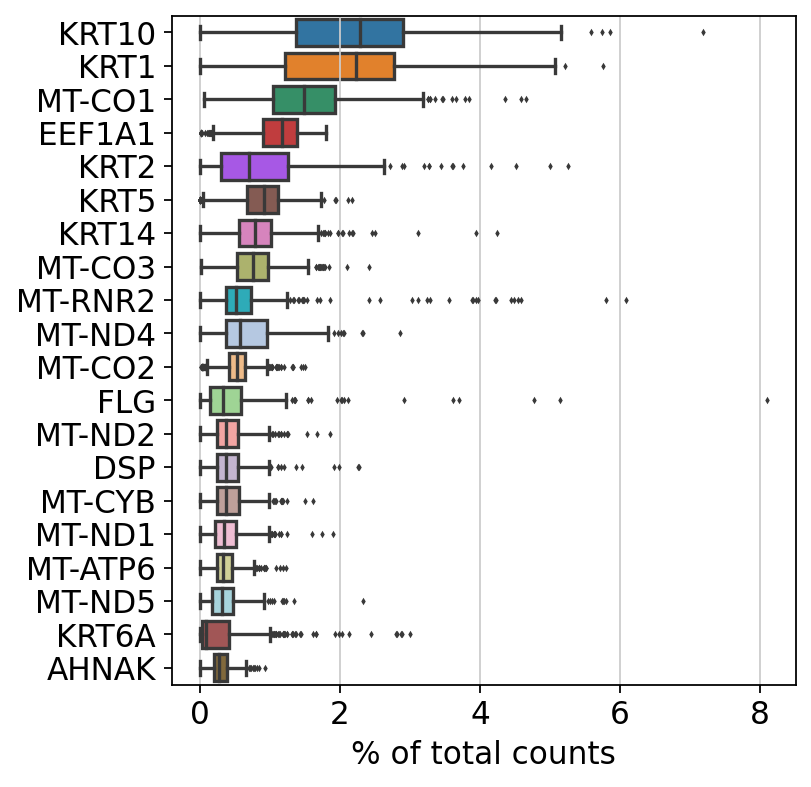

['leiden',
 'source_name_ch1KRT10',
 'KRT1',
 'FLG',
 'DA',
 'SOX6',
 'CORIN',
 'PITX2',
 'MKI67']

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


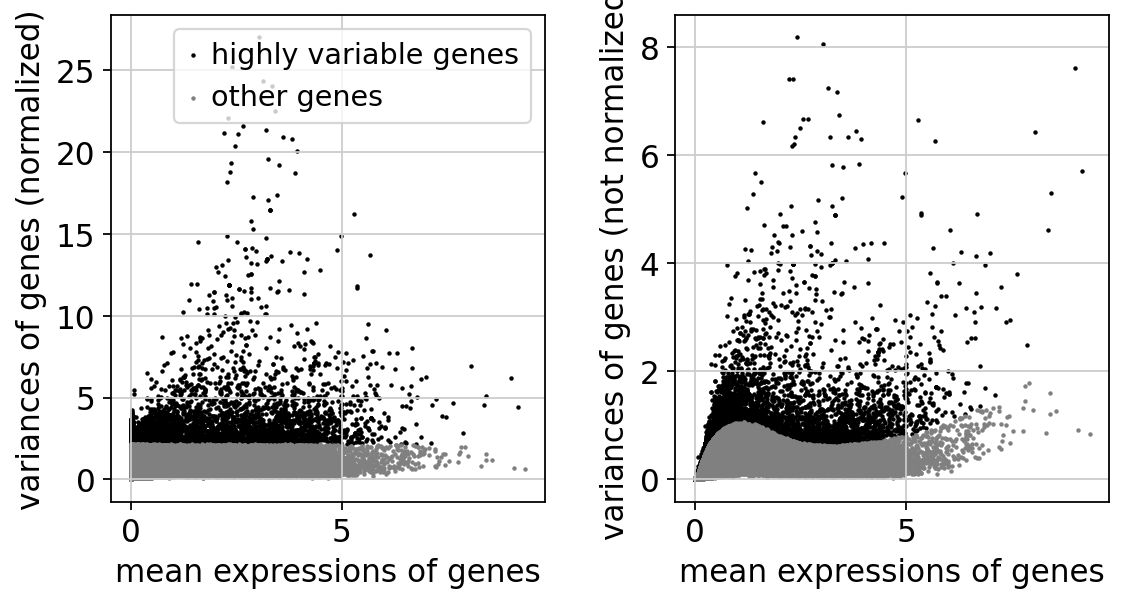

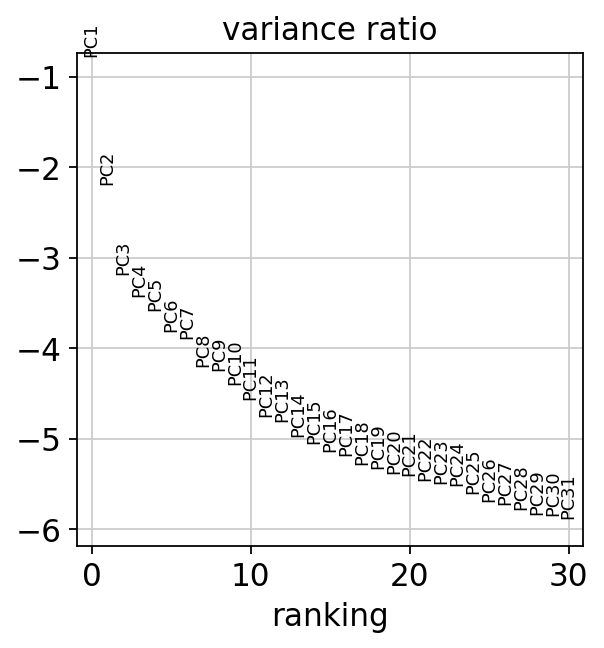

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


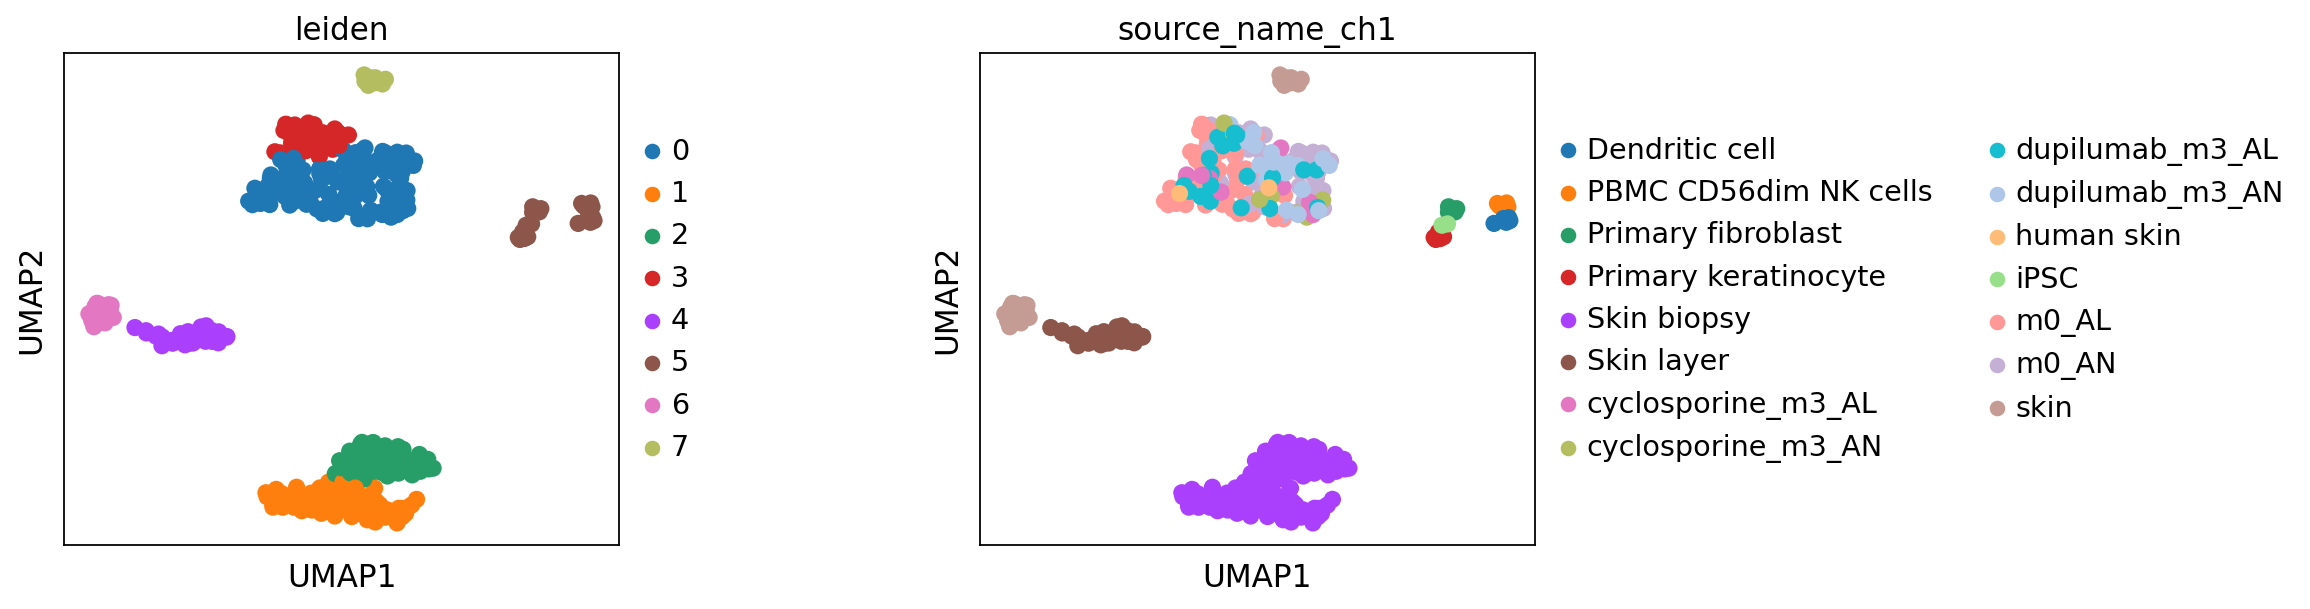

In [10]:
####    save raw counts and CPM to layers and freeze the raw data (CPMs) in .raw
adata.layers["salmon_counts"]=adata.X
sc.pp.normalize_total(adata, target_sum=1e6)
adata.layers["salmon_CPM"]=adata.X.copy()
# set raw data to salmon_CPM ### this is the data that will be used for coloring plots
adata.raw=adata.copy()
### now log
sc.pp.log1p(adata)
###  HVG selection 
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    #subset=True,
    #layer="salmon_counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)
### wait dont really filter forr HVG (HVGs still marked in adata.var['highly_variable'])
#adata = adata[:, adata.var.highly_variable].copy()

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

####### Computing the neighborhood graph
## reduce n_pcs if larger than number of samples or 50 
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=.5)
adata

## some UMAP scatter plots

# Custom colormap where zero and bottom 10% values are represented by grey
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                              ['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                                 list(plt.cm.viridis(np.linspace(0, 1, 90))))

sc.pl.umap(adata,
          color= ['leiden','source_name_ch1',#'characteristics_ch1'
                  ],wspace=.5,ncols=4,size=240,cmap =cmap)

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


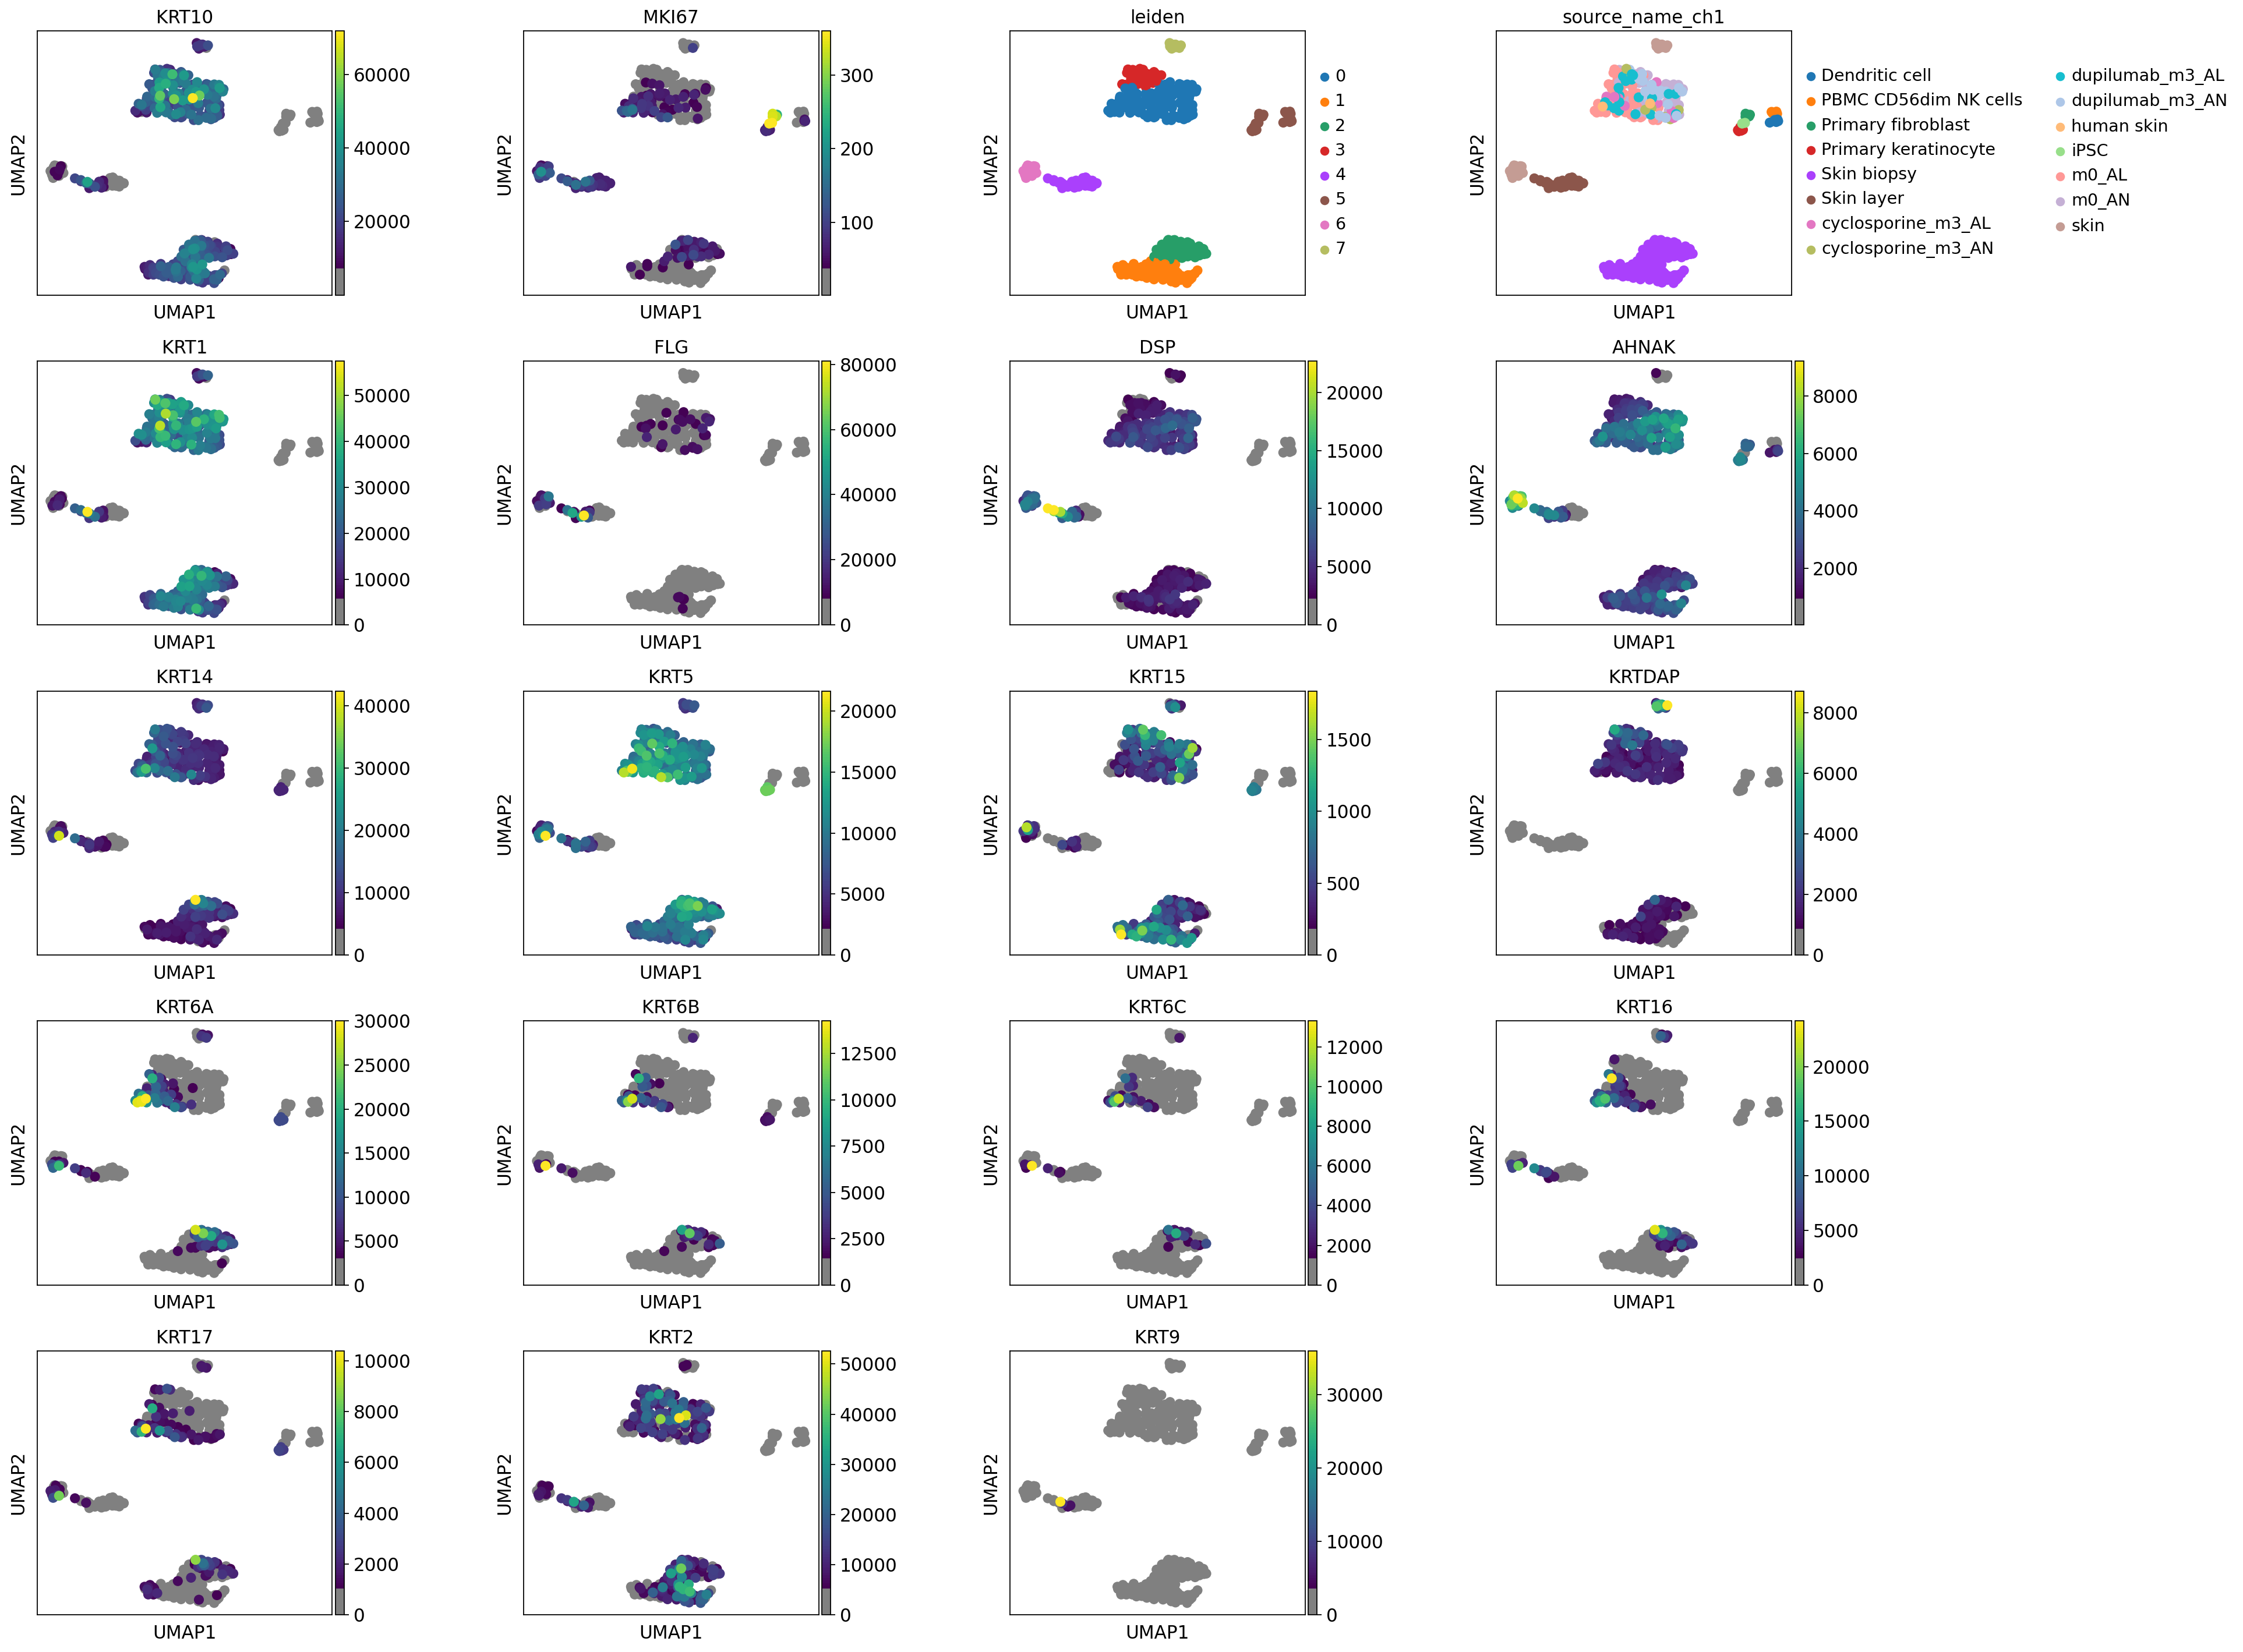

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


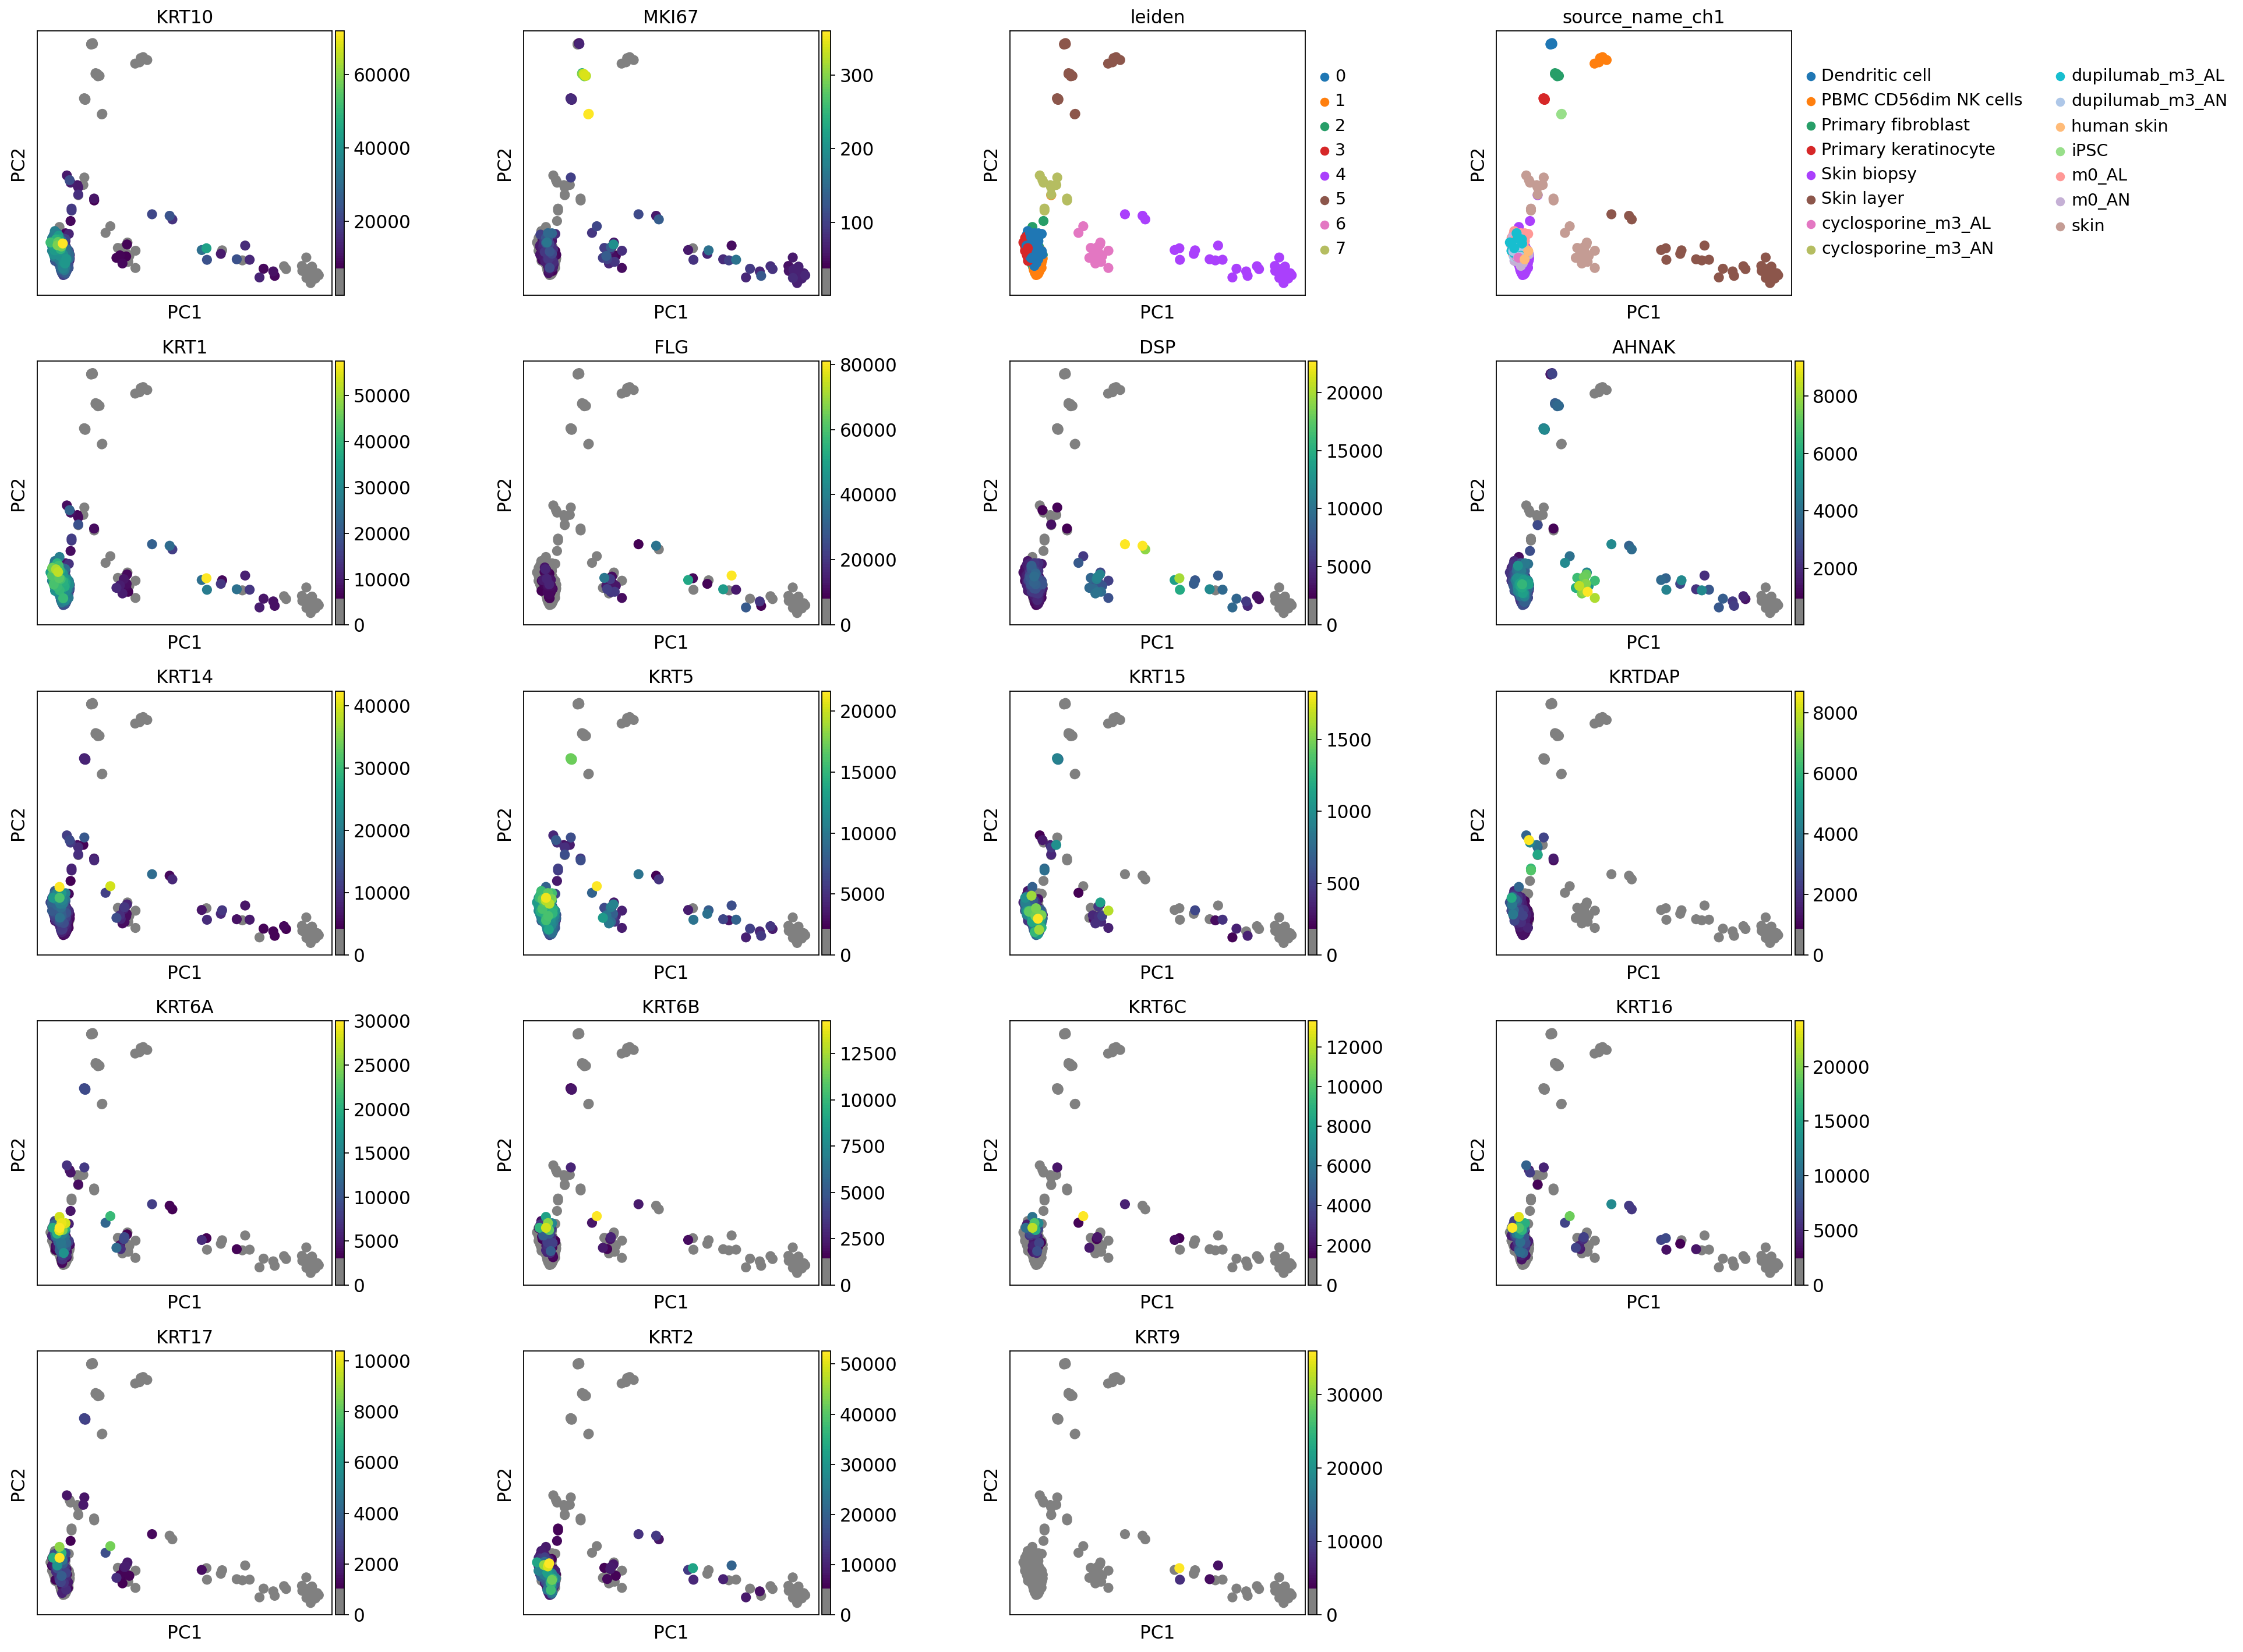

In [17]:
## some UMAP scatter plots

# Custom colormap where zero and bottom 10% values are represented by grey
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                              ['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                                 list(plt.cm.viridis(np.linspace(0, 1, 90))))
sc.pl.umap(adata,
          color= [ 'KRT10','MKI67','leiden','source_name_ch1',
                 'KRT1','FLG','DSP',
                  'AHNAK','KRT14','KRT5','KRT15','KRTDAP','KRT6A','KRT6B','KRT6C','KRT16','KRT17','KRT2','KRT9'
                  ]
                  ,wspace=.5,ncols=4,size=240,cmap =cmap)

sc.pl.pca(adata,
          color= ['KRT10','MKI67','leiden','source_name_ch1',
                  'KRT1','FLG','DSP',
                  'AHNAK','KRT14','KRT5','KRT15','KRTDAP','KRT6A','KRT6B','KRT6C','KRT16','KRT17','KRT2','KRT9'
                  ],wspace=.5,ncols=4,size=240,cmap =cmap)

## step by step example for loading ARCHS4_H5_file and extracting subset of samples into an adata

### load data

In [9]:
!h5ls -r /home/ubuntu/data/ARCHS4/human_gene_v2.2.h5

/                        Group
/data                    Group
/data/expression         Dataset {67186, 722425/Inf}
/meta                    Group
/meta/genes              Group
/meta/genes/biotype      Dataset {67186}
/meta/genes/ensembl_gene_id Dataset {67186}
/meta/genes/symbol       Dataset {67186}
/meta/info               Group
/meta/info/author        Dataset {SCALAR}
/meta/info/contact       Dataset {SCALAR}
/meta/info/creation-date Dataset {SCALAR}
/meta/info/laboratory    Dataset {SCALAR}
/meta/info/version       Dataset {SCALAR}
/meta/samples            Group
/meta/samples/channel_count Dataset {722425}
/meta/samples/characteristics_ch1 Dataset {722425}
/meta/samples/contact_address Dataset {722425}
/meta/samples/contact_city Dataset {722425}
/meta/samples/contact_country Dataset {722425}
/meta/samples/contact_institute Dataset {722425}
/meta/samples/contact_name Dataset {722425}
/meta/samples/contact_zip Dataset {722425}
/meta/samples/data_processing Dataset {722425}
/meta/sa

In [10]:
%%time

#from G.ARCHS4_H5_file
print(G.ARCHS4_H5_file) 
ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
print("Groups in HDF5 file:")
for group in list(ARCHS4_H5.keys()):
    print(group)
    for sub_group in list(ARCHS4_H5[group].keys()):
        print(f'    {sub_group}')
   



/home/ubuntu/data/ARCHS4/human_gene_v2.2.h5
Groups in HDF5 file:
data
    expression
meta
    genes
    info
    samples
CPU times: user 2.09 ms, sys: 247 µs, total: 2.34 ms
Wall time: 2.63 ms


### load the metadata

In [11]:
df_meta_src=load_ARCHS4_H5_to_df( G.ARCHS4_H5_file )
print(df_meta_src.shape)
#df_meta_src.to_csv('meta_samples.csv', index=False)
#df_meta_src=pd.read_csv('meta_samples.csv')
df_meta=df_meta_src.copy()
df_meta.head(2)

(722425, 30)


,geo_accession,title,type,characteristics_ch1,source_name_ch1,sample,series_id,molecule_ch1,extract_protocol_ch1,readsaligned,library_selection,library_source,library_strategy,singlecellprobability,submission_date,data_processing,status,last_update_date,channel_count,organism_ch1,taxid_ch1,platform_id,instrument_model,relation,contact_name,contact_address,contact_city,contact_zip,contact_country,contact_institute
0,GSM1000981,OCI-LY1_48hrs_mRNAseq_3x_siNT_R1,SRA,"treatment: siNT,cell line: OCI-LY1",Human DLBCL cel line,GSM1000981,GSE29282,total RNA,ChIP-seq libraries were prepared using the Ill...,102963402,cDNA,transcriptomic,RNA-Seq,0.007336,Sep 10 2012,ChIP-seq: Raw images generated went through pr...,Public on Aug 05 2013,May 15 2019,1,Homo sapiens,9606,GPL15433,Illumina HiSeq 1000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,"Katerina,,Hatzi","413 E 69th Street, BB-1462",New York,,USA,WCMC
1,GSM1000982,OCI-LY1_48hrs_mRNAseq_3x_siNT_R2,SRA,"treatment: siNT,cell line: OCI-LY1",Human DLBCL cel line,GSM1000982,GSE29282,total RNA,ChIP-seq libraries were prepared using the Ill...,85980162,cDNA,transcriptomic,RNA-Seq,-0.006492,Sep 10 2012,ChIP-seq: Raw images generated went through pr...,Public on Aug 05 2013,May 15 2019,1,Homo sapiens,9606,GPL15433,Illumina HiSeq 1000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,"Katerina,,Hatzi","413 E 69th Street, BB-1462",New York,,USA,WCMC


#### check out the compositin of columns

Homo sapiens    722425
Name: organism_ch1, dtype: int64
RNA-Seq    722425
Name: library_strategy, dtype: int64
cDNA                  719170
CAGE                    2080
size fractionation       874
RACE                     265
RANDOM                    20
other                     16
Name: library_selection, dtype: int64
total RNA          526089
polyA RNA          194774
nuclear RNA           718
genomic DNA           464
cytoplasmic RNA       263
protein                82
other                  35
Name: molecule_ch1, dtype: int64


<AxesSubplot: >

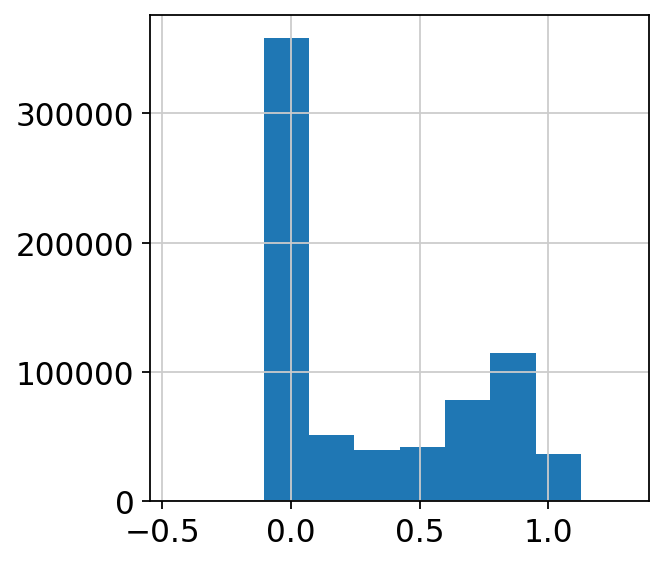

In [12]:
print(df_meta['organism_ch1'].value_counts())
print(df_meta['library_strategy'].value_counts())
print(df_meta['library_selection'].value_counts())
print(df_meta['molecule_ch1'].value_counts()) # RNA
#print(df['type'].value_counts())
#print(df['status'].value_counts())
#print(df['platform_id'].value_counts())
#print(df['instrument_model'].value_counts())
#print(df['relation'].value_counts())
#print(df['series_id'].value_counts())
#print(df['sra_id'].value_counts())
#print(df['data_processing'].value_counts())
df_meta['singlecellprobability'].hist()

### filter  the data

#### now do a basic filter for RNA gene expression and some cut off for single cell probability

(722425, 30)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.2
(398669, 30)


<AxesSubplot: >

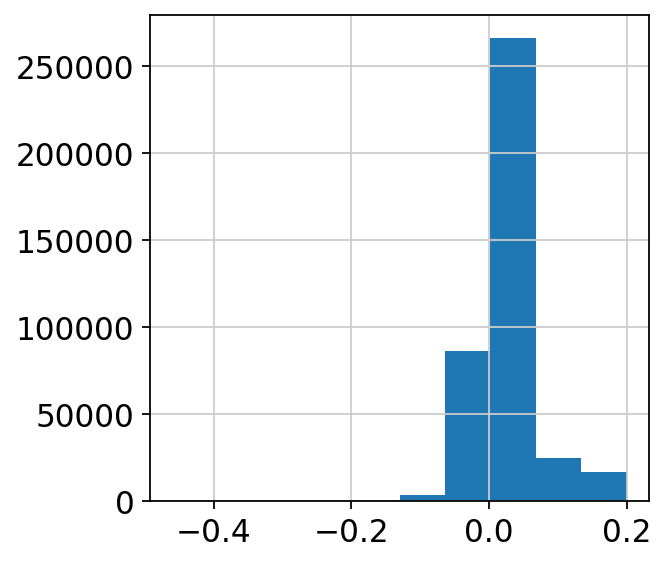

In [13]:
df_meta=df_meta_src.copy()
print(df_meta.shape)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=.2)
print(df_meta.shape)
#df_meta.to_csv('meta_samples_small.csv', index=False)
df_meta['singlecellprobability'].hist()

In [14]:
df_meta.tail(3)   


,geo_accession,title,type,characteristics_ch1,source_name_ch1,sample,series_id,molecule_ch1,extract_protocol_ch1,readsaligned,library_selection,library_source,library_strategy,singlecellprobability,submission_date,data_processing,status,last_update_date,channel_count,organism_ch1,taxid_ch1,platform_id,instrument_model,relation,contact_name,contact_address,contact_city,contact_zip,contact_country,contact_institute
722421,GSM999588,Parkinson's Disease PD 14,SRA,"tissue: Human brain cortex (BA9),disease state...",Brain cortex,GSM999588,GSE40710,polyA RNA,RNA was extracted from frozen brain tissue usi...,2283349,cDNA,transcriptomic,RNA-Seq,0.009471,Sep 08 2012,Illumina reads were converted to FASTQ Sanger ...,Public on Oct 04 2012,May 15 2019,1,Homo sapiens,9606,GPL11154,Illumina HiSeq 2000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,"Herve,,RHINN",650 W. 168th. St.,New York,,USA,Columbia University
722422,GSM999589,Parkinson's Disease PD 15,SRA,"tissue: Human brain cortex (BA9),disease state...",Brain cortex,GSM999589,GSE40710,polyA RNA,RNA was extracted from frozen brain tissue usi...,3253397,cDNA,transcriptomic,RNA-Seq,0.083552,Sep 08 2012,Illumina reads were converted to FASTQ Sanger ...,Public on Oct 04 2012,May 15 2019,1,Homo sapiens,9606,GPL11154,Illumina HiSeq 2000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,"Herve,,RHINN",650 W. 168th. St.,New York,,USA,Columbia University
722424,GSM999591,Parkinson's Disease PD 17,SRA,"tissue: Human brain cortex (BA9),disease state...",Brain cortex,GSM999591,GSE40710,polyA RNA,RNA was extracted from frozen brain tissue usi...,1162666,cDNA,transcriptomic,RNA-Seq,0.019685,Sep 08 2012,Illumina reads were converted to FASTQ Sanger ...,Public on Oct 04 2012,May 15 2019,1,Homo sapiens,9606,GPL11154,Illumina HiSeq 2000,SRA: https://www.ncbi.nlm.nih.gov/sra?term=SRX...,"Herve,,RHINN",650 W. 168th. St.,New York,,USA,Columbia University


#### now all do a new filter

In [15]:
#### now all do a new filter
df_meta=df_meta_src.copy()
min_singlecellprobability=.5
print(df_meta.shape)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=min_singlecellprobability)
print(df_meta.shape)
# list of Strings to check for to include
#search_strings=['exitatory', 'Exitatory',  'glutamatergic', 'Glutamatergic']
search_strings_include=['dermatitis', 'Dermatitis']
df_meta=filter_df(df_meta, search_strings_include, include=True,ignore_columns=['data_processing'] )
print(df_meta.shape)
# list of Strings to check for to exclude
#search_strings_exclude=['GABAergic', 'gabaergic', 'GABA', 'gaba', 'inhibitory', 'Inhibitory']
#df=filter_df(df, search_strings_exclude, include=False,ignore_columns=None)
print(df_meta.shape)
#df.to_csv('meta_samples_small_dermatitis.csv', index=False)
df_meta.head(3)


(722425, 30)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.5
(463217, 30)
filtering to include ['dermatitis', 'Dermatitis']
(387, 30)
(387, 30)


,geo_accession,title,type,characteristics_ch1,source_name_ch1,sample,series_id,molecule_ch1,extract_protocol_ch1,readsaligned,library_selection,library_source,library_strategy,singlecellprobability,submission_date,data_processing,status,last_update_date,channel_count,organism_ch1,taxid_ch1,platform_id,instrument_model,relation,contact_name,contact_address,contact_city,contact_zip,contact_country,contact_institute
275024,GSM3584918,AD pt1,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584918,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,18889411,cDNA,transcriptomic,RNA-Seq,0.076691,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis
275025,GSM3584919,AD pt2,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584919,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,19169479,cDNA,transcriptomic,RNA-Seq,0.043671,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis
275028,GSM3584922,AD pt3,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584922,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,23714976,cDNA,transcriptomic,RNA-Seq,0.020970,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis


### now load the gene expression data using the geo_accession column from the filtered meta data df 

### generate an adata object

In [16]:
filtered_metadata_df=df_meta.copy()
adata=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=False)
print(adata)
adata.obs.head(3)

AnnData object with n_obs × n_vars = 387 × 67186
    obs: 'geo_accession', 'title', 'type', 'characteristics_ch1', 'source_name_ch1', 'sample', 'series_id', 'molecule_ch1', 'extract_protocol_ch1', 'readsaligned', 'library_selection', 'library_source', 'library_strategy', 'singlecellprobability', 'submission_date', 'data_processing', 'status', 'last_update_date', 'channel_count', 'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute', 'ARCHS4_idx'
    var: 'ensembl_gene_id', 'biotype'


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,geo_accession,title,type,characteristics_ch1,source_name_ch1,sample,series_id,molecule_ch1,extract_protocol_ch1,readsaligned,library_selection,library_source,library_strategy,singlecellprobability,submission_date,data_processing,status,last_update_date,channel_count,organism_ch1,taxid_ch1,platform_id,instrument_model,relation,contact_name,contact_address,contact_city,contact_zip,contact_country,contact_institute,ARCHS4_idx
GSM3584918,GSM3584918,AD pt1,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584918,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,18889411,cDNA,transcriptomic,RNA-Seq,0.076691,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis,275024
GSM3584919,GSM3584919,AD pt2,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584919,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,19169479,cDNA,transcriptomic,RNA-Seq,0.043671,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis,275025
GSM3584922,GSM3584922,AD pt3,SRA,sort population: Live CD45+ CD13- CD3- CD56dim...,PBMC CD56dim NK cells,GSM3584922,GSE125916,total RNA,Cells were sorted directly into lysis buffer c...,23714976,cDNA,transcriptomic,RNA-Seq,0.020970,Jan 30 2019,"Sequences were aligned with STAR v2.0.4b,Gene ...",Public on Feb 03 2020,Feb 04 2020,1,Homo sapiens,9606,GPL21290,Illumina HiSeq 3000,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,"Madison,R,Mack",425 S. Euclid Ave. CSRB 6649,Saint Louis,,USA,Washington University in St. Louis,275028


In [17]:
adata.var.head(3)

,ensembl_gene_id,biotype
TSPAN6,ENSG00000000003,protein_coding
TNMD,ENSG00000000005,protein_coding
DPM1,ENSG00000000419,protein_coding


### generate an data frame object

In [18]:
filtered_metadata_df=df.copy()
df_gex=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=True)
df_gex.head(3)

NameError: name 'df' is not defined

### further anlaysis of the data 

### save processed data

# Analysis ends here